# Testing PCA Class

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from PCA import PCA
from LeastSquares import LeastSquares
%matplotlib notebook 

In [2]:
freq = [0.01, 0.022, 0.045, 0.408, 1.42,2.326] #6 frequencies
freq_arr = (np.array(freq)).reshape(len(freq),1) #creating freq array (6x1)
pca = PCA(freq) #object of PCA class
ls = LeastSquares(freq_arr) #object of LeastSquares class

clean_matrix,clean_dict = pca.data_matrix('all_overlap.npz') #data matrix for clean data
noisy_matrix,noisy_dict = pca.data_matrix('real_noisy.npz') #data matrix for noisy data
blur_matrix,blur_dict = pca.data_matrix('blurry_data.npz') #data matrix for blurred data
blur_noisy_matrix,blur_noisy_dict = pca.data_matrix('blurry_noisy_data.npz') #data matrix for blurred noisy data

## Dividing Spectra by Average (Power Law)

Using the <strong>LeastSquares</strong> class, I fitted the average of the spectra to a power law. Then, I divided the whole spectra by that power law to create a more flattened curve. The <strong>ymodel</strong> function for the power law returns the y model or <strong>pow_freq_fit</strong> in the form 

$$\bar{y} = \begin{bmatrix}
log(y_{1}) \\
log(y_{2}) \\
\vdots \\
\end{bmatrix}$$

Since it is the log of the y values, I took the exponential of that log (line 6) to get the actual y value. With that, I don't need to graph the new spectra on a log-log graph.

In [15]:
freq_pow = ls.pow_matrix() #data matrix for power law model
mean_y = np.mean(clean_matrix, axis = 0) #mean of clean spectra
log_mean_y = (np.log(mean_y)).reshape(mean_y.shape[0],1) #log of mean and reshaping (6x1)

pow_freq_fit, pow_freq_param, pow_error = ls.ymodel(freq_pow, log_mean_y) #fit for model (y values), parameters, error
fit_y = np.exp(pow_freq_fit) #taking exponential of pow_freq_fit to get y value

In [4]:
num_rows = clean_matrix.shape[0] #number of rows of clean matrix
num_col = clean_matrix.shape[1] #number of columns of clean matrix
avg_clean_matrix = np.zeros((num_rows,num_col)) #creating empty array to store values

for i in np.arange(num_rows):
    #dividing each row of clean matrix by average data 
    avg_clean_matrix[i] = np.divide(clean_matrix[i].reshape(1,num_col),fit_y.reshape(1,num_col)) #storing it in avg_clean_matrix
    
avg_clean_dict = dict(zip(freq,(avg_clean_matrix[:,i] for i in range(avg_clean_matrix.shape[0])))) 

## Determining Eigenvalues and Eigenvectors

In [16]:
cov,stand_matrix = pca.cov_matrix(clean_matrix) #covariance and standardized data matrix
corr = pca.corr_matrix(clean_matrix) #correlation matrix
avg_cov,s = pca.cov_matrix(avg_clean_matrix) #covariance for spectra divided by the average
noisy_cov,noisy_stand_matrix = pca.cov_matrix(noisy_matrix) #covariance of noisy data

#eigvenvalues and eigenvectors for covariance
eigval,eigvec,eigpairs = pca.eig_values(cov)
eigval_dict = pca.ordered_eigval(eigval)

#eigvenvalues and eigenvectors for correlation
eigval2,eigvec2,eigpairs2 = pca.eig_values(corr)
eigval_dict2 = pca.ordered_eigval(eigval2)

#eigenvalues and eigenvectors for data divided by averaged
eigval3,eigvec3,eigpairs3 = pca.eig_values(avg_cov)
eigval_dict3 = pca.ordered_eigval(eigval3)

#eigenvalues and eigenvectors for noisy data
eigval4,eigvec4,eigpairs4 = pca.eig_values(noisy_cov)
eigval_dict4 = pca.ordered_eigval(eigval4)

## Plotting Eigenvalues and Eigenvectors

<IPython.core.display.Javascript object>


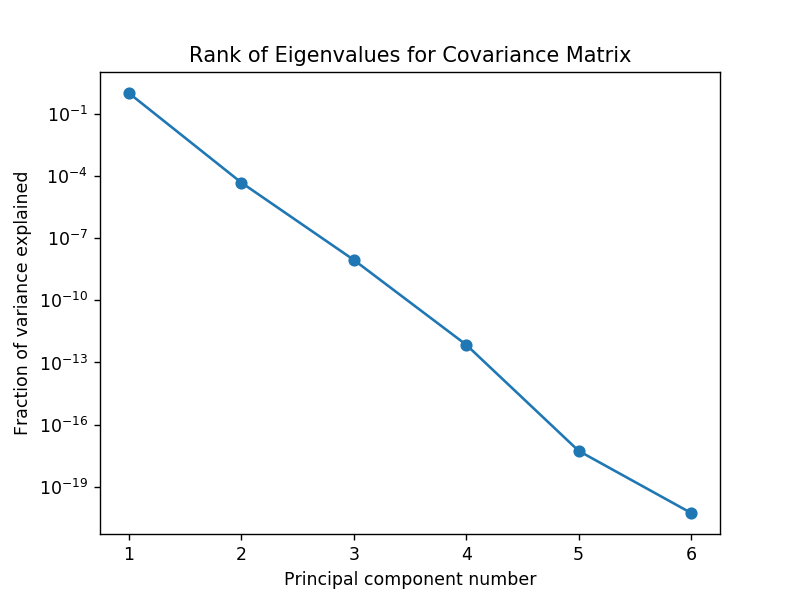

<IPython.core.display.Javascript object>


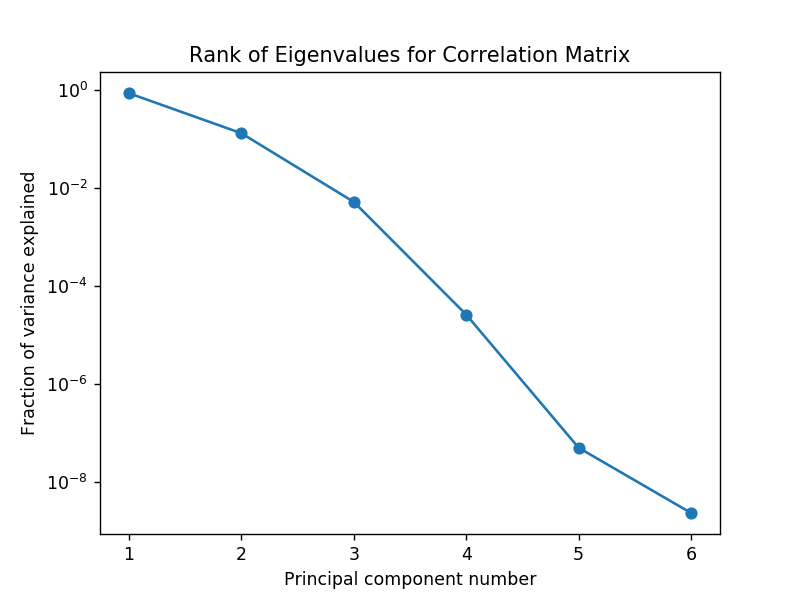

<IPython.core.display.Javascript object>


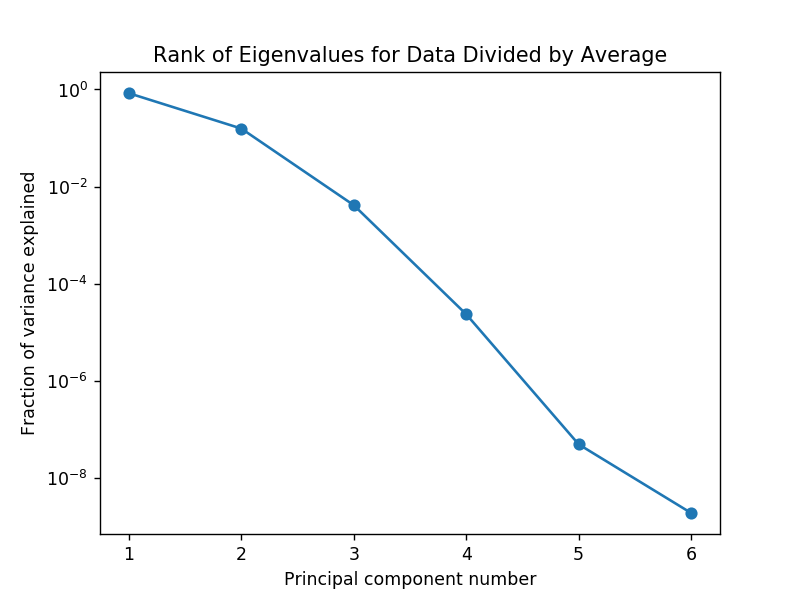

<IPython.core.display.Javascript object>


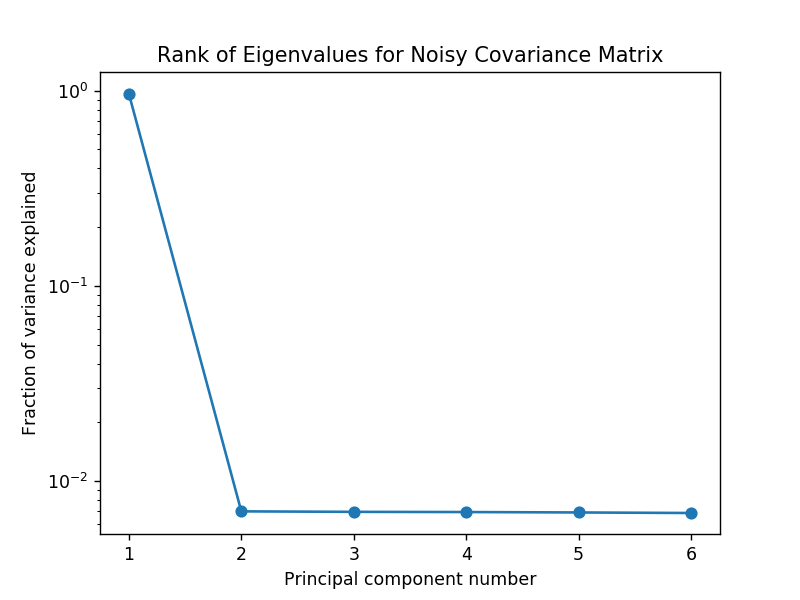

In [24]:
pca.graph_eigval('Rank of Eigenvalues for Covariance Matrix',eigval_dict)
pca.graph_eigval('Rank of Eigenvalues for Correlation Matrix',eigval_dict2)
pca.graph_eigval('Rank of Eigenvalues for Data Divided by Average',eigval_dict3)
pca.graph_eigval('Rank of Eigenvalues for Noisy Covariance Matrix',eigval_dict4)

<IPython.core.display.Javascript object>


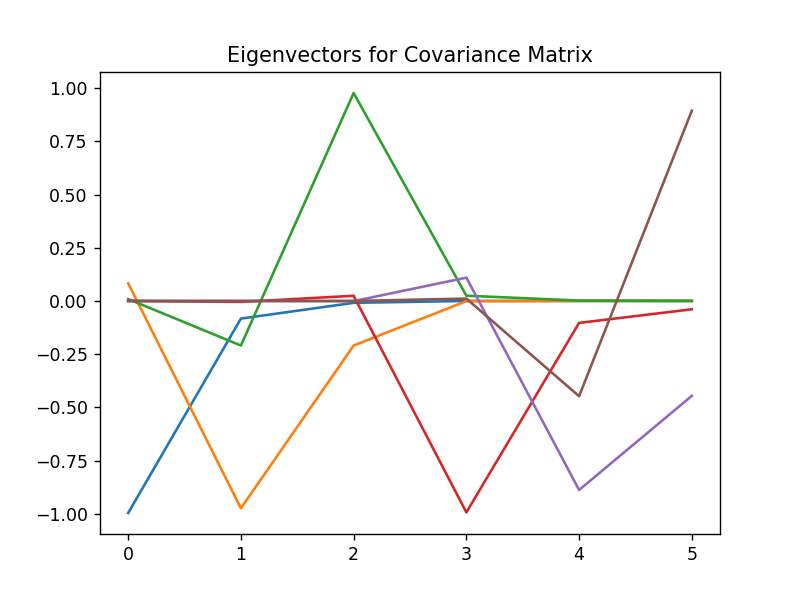

<IPython.core.display.Javascript object>


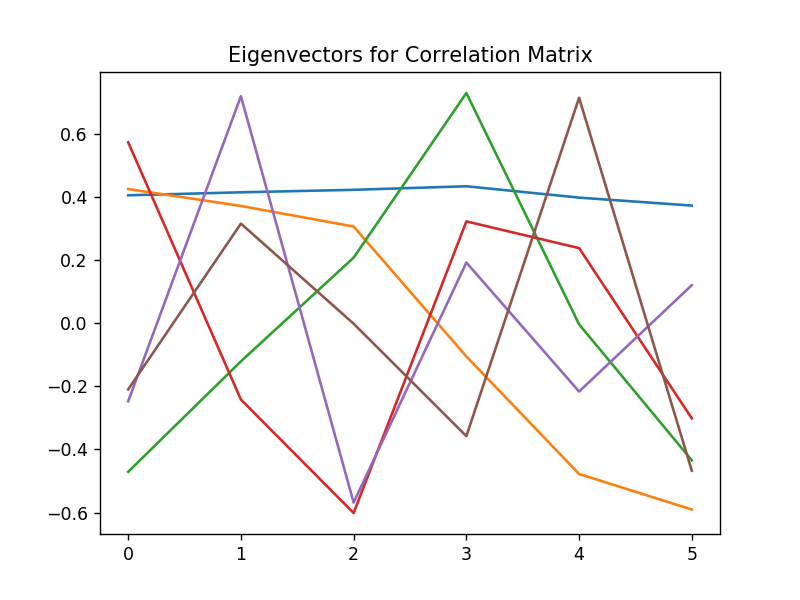

In [7]:
plt.figure()
plt.title('Eigenvectors for Covariance Matrix')
for i in np.arange(eigvec.shape[1]):
    plt.plot(eigvec[:,i])
#     plt.quiver([0,0],*eigvec[:,i],scale=1.15,color='b')
plt.show()

plt.figure()
plt.title('Eigenvectors for Correlation Matrix')
for i in np.arange(eigvec.shape[1]):
    plt.plot(eigvec2[:,i])
#     plt.quiver([0,0],*eigvec2[:,i],scale=1.15,color='orange')
plt.show()

## Testing Principal Component Fits

We can write the spectra as a linear combination of the eigenvectors so that
$$\vec{s} = a_{1}\vec{v_{1}} + a_{2}\vec{v_{3}} + a_{3}\vec{v_{3}} +\ldots= \sum_{i}^{p}{a_{i}\vec{v_{i}}} $$
where $ \{a_{1},a_{2},\ldots\} $ is the expansion coefficient. Through this, we form a different basis with the eigenvectors. 

Now, how do we find the coefficients? We can rewrite this in matrix form where the spectra $S$ is a $nxp$ matrix so that
$$S = \begin{bmatrix}
    a_{1} \\
    a_{2} \\
    \vdots \\
    a_{n} \\
    \end{bmatrix} * [\vec{v_{1}} \vec{v_{2}} \ldots \vec{v_{p}}]$$
    
This looks similar to a least squares problem where we are trying to find the parameters, or, in this case, the coefficients for the eigenvectors. Using this reasoning, I used the <strong>ymodel</strong> function from the <strong>LeastSquares</strong> class which returns the values for the fit, parameters, and the error covariance. Since the <strong>ymodel</strong> function already returns the new fit based on the principal components, I didn't need to recalculate it using the coefficients and eigenvectors.

In [8]:
total_fit,total_coef,total_err = ls.ymodel(eigvec,clean_matrix.T) #fit for all principal components (pc)
one_fit,one_coef,one_err = ls.ymodel(eigvec[:,0].reshape(eigvec.shape[0],1),clean_matrix.T) #first pc
two_fit,two_coef,two_err = ls.ymodel(eigvec[:,:2].reshape(eigvec.shape[0],2),clean_matrix.T) #first two pc

In the graphs, I plotted the fit for the principal components using different amounts of the principal componenets: all of the principal components, the first principal component, and the first two prinicpal components. 

<IPython.core.display.Javascript object>


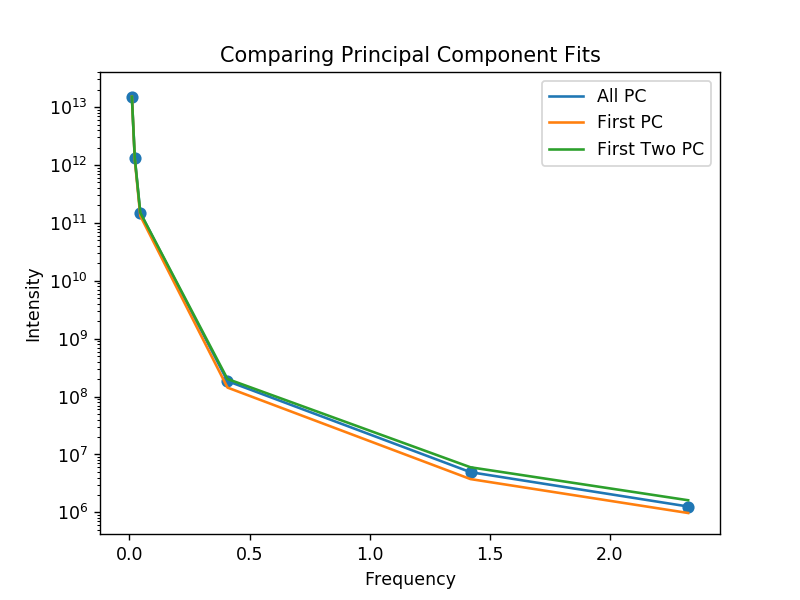

<IPython.core.display.Javascript object>


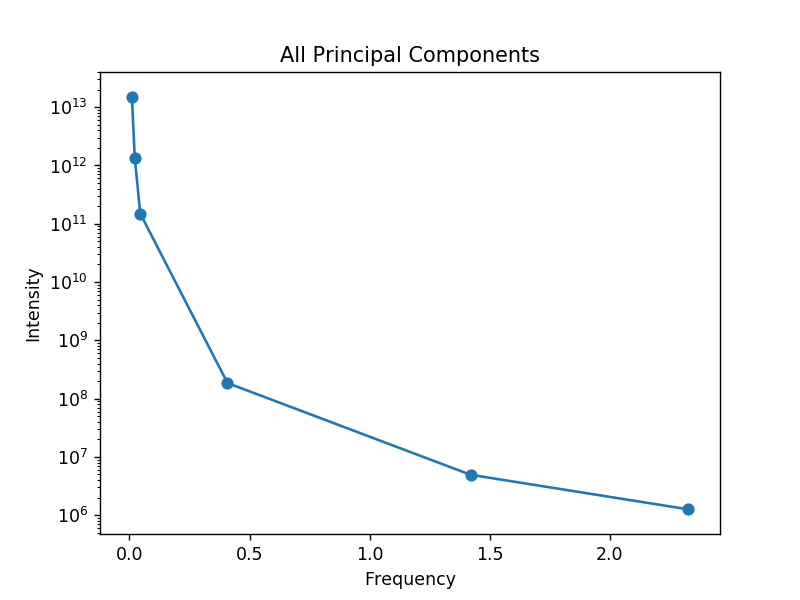

<IPython.core.display.Javascript object>


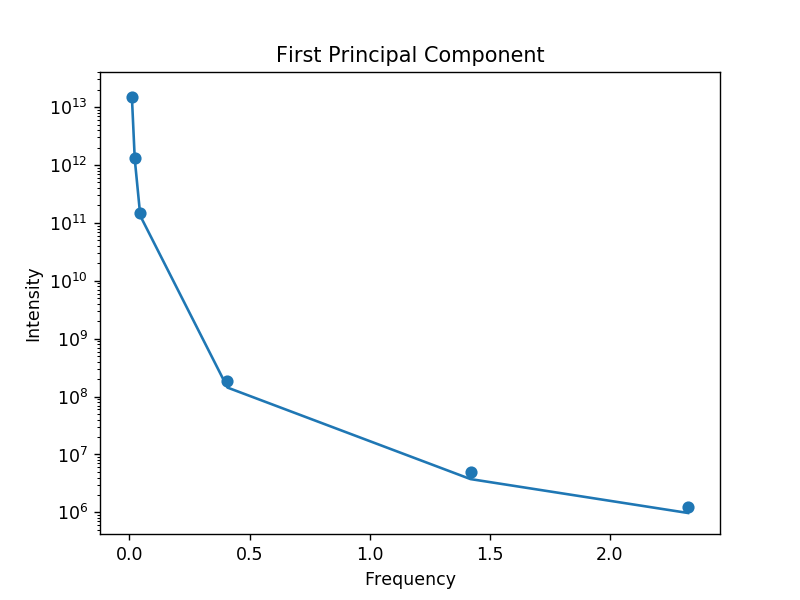

<IPython.core.display.Javascript object>


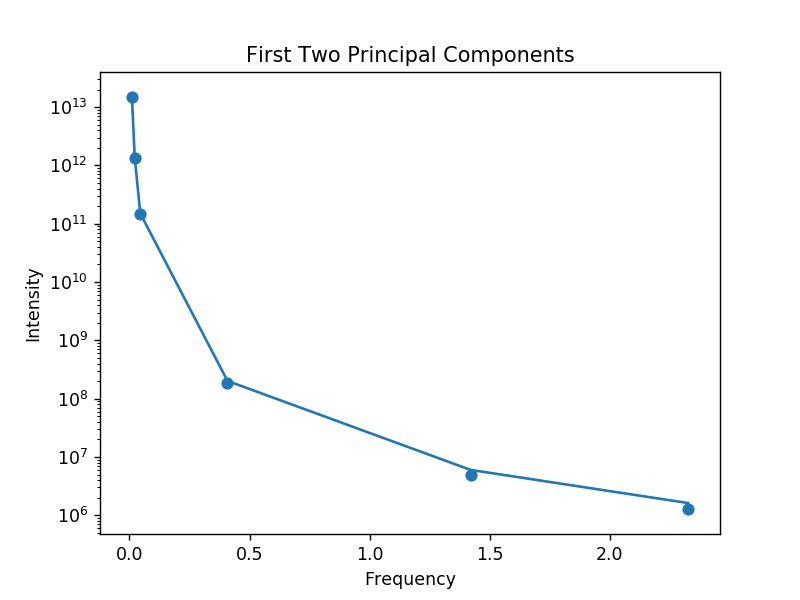

In [23]:
pixel = 160000

plt.figure()
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('Comparing Principal Component Fits')
plt.plot(freq,total_fit[:,pixel], label='All PC')
plt.plot(freq,one_fit[:,pixel], label = 'First PC')
plt.plot(freq,two_fit[:,pixel], label = 'First Two PC')
plt.legend(loc='upper right')
plt.scatter(freq,clean_matrix[pixel])

plt.figure()
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('All Principal Components')
# for i in np.arange(0,100000,10000):
plt.plot(freq,total_fit[:,pixel])
plt.scatter(freq,clean_matrix[pixel])
# plt.plot(freq,clean_matrix[0],color='orange')

plt.figure()
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('First Principal Component')
# for i in np.arange(5):
plt.plot(freq,one_fit[:,pixel])
plt.scatter(freq,clean_matrix[pixel])

plt.figure()
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('First Two Principal Components')
# for i in np.arange(5):
plt.plot(freq,two_fit[:,pixel])
plt.scatter(freq,clean_matrix[pixel])

## Comparing Power Slope from Clean Data and Blurred Data

In [10]:
clean_pow_slope = np.zeros(clean_matrix.shape[0]) #array of power slopes for clean data
blur_pow_slope = np.zeros(blur_matrix.shape[0]) #array of power slopes for smooth data

for i in np.arange(clean_matrix.shape[0]):
    log_clean = (np.log(clean_matrix[i])).reshape(clean_matrix.shape[1],1) #taking log of row of matrix
    p,param,er = ls.ymodel(freq_pow,log_clean)
    clean_pow_slope[i] = param[1] 
# smooth_matrix
for i in np.arange(blur_matrix.shape[0]):
    log_blur = (np.log(blur_matrix[i])).reshape(blur_matrix.shape[1],1)
    p,param,er = ls.ymodel(freq_pow,log_blur)
    blur_pow_slope[i] = param[1]

In [11]:
print(clean_pow_slope)
print('\n',blur_pow_slope)

[-3.0522431  -3.05254946 -3.03243127 ... -2.96707444 -2.96434784
 -2.97088699]

 [-3.48252321 -3.48282362 -3.48316688 ... -3.54485118 -3.54443703
 -3.543956  ]


## Plotting Spectra

<IPython.core.display.Javascript object>


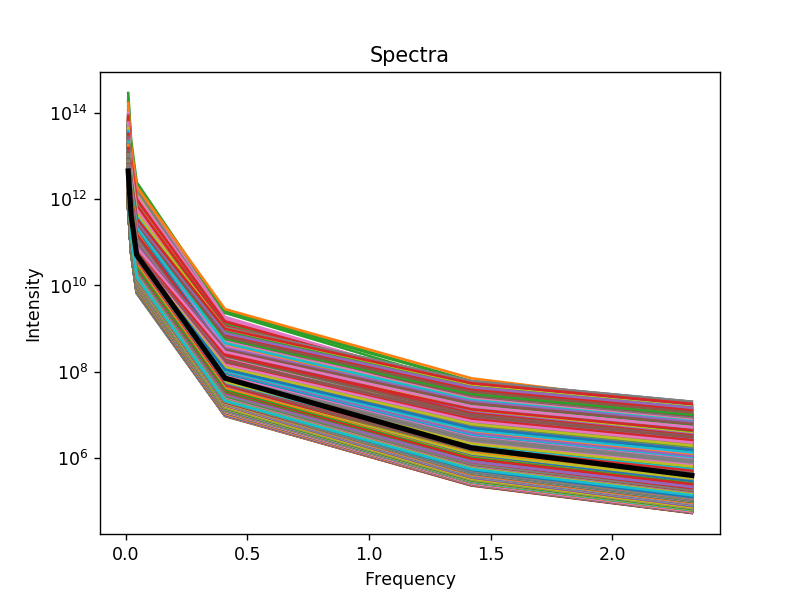

Wall time: 1min 16s


In [12]:
%%time

plt.figure()
plt.plot(list(clean_dict.keys()),list(clean_dict.values()))
plt.plot(freq,fit_y,linewidth = 3, color = 'black')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('Spectra')
plt.show()

In [ ]:
# %%time

# plt.figure()
# plt.plot(list(noisy_dict.keys()),list(noisy_dict.values()))
# plt.yscale('log')
# plt.title('Noisy')
# plt.show()

In [ ]:
# %%time 

# plt.figure()
# plt.plot(list(avg_clean_dict.keys()),list(avg_clean_dict.values()))
# plt.title('Divided Clean by Average (power law)')
# plt.show()

In [ ]:
# %%time

# plt.figure()
# plt.plot(list(blur_dict.keys()),list(blur_dict.values()))
# plt.yscale('log')
# plt.title('Smooth')
# plt.show()